<a href="https://colab.research.google.com/github/RonnyGuevara/Digital-image-processing/blob/main/TP7/Pr%C3%A1ctica_7_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Práctica 7:  Procesamiento Morfológico

##Presentado por: Ronny Guevara

## Objetivo General
Filtrar una imagen utilizando técnicas morfológicas
## Objetivos Específicos
*   Construir filtros morfológicos de erosión, dilatación, apertura, cierre, bordes, mediana y top_hat
*   Visualización de resultados en una interfaz amigable con el usuario

## Descripción del práctico:
Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:


*   Erosión (tomar el mínimo valor de luminancia de la vecindad)
*   Dilatación (máximo)
*   Apertura
*   Cierre
*   Borde morfológico (frontera interna y externa)
*   Mediana
*   Top-hat




In [1]:
#Librerías a utilizar
import imageio as io
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
#Función que permite leer una imagen sin limitación de UNIT8
def get_image(dir):
  image = io.imread(dir)
  image = image.astype(np.int)
  return image

#Función que permite plotear la imagen
def plot2_image(image,Imagen, cmap=None):
  plt.figure(figsize=(100,100)) 
  plt.figure()
  plt.title(Imagen)
  plt.imshow(image,cmap=cmap)
  plt.grid(False)
  plt.show()

#Copia de la imagen Original
def image_copy(image):
  work_image=np.copy(image)
  return work_image 

#Información de la imagen
def image_info(image):
  print('This image is', image.dtype)
  print('with dimensions', image.shape)

#Normalización de las imágenes
def image_norm(image):
  norm=image.astype(np.float64)/255
  return norm

#Conversión RGB2YIQ
def image_RGB2YIQ(image):
  matrixYIQ=np.array([[0.299,0.587,0.144],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
  YIQ=np.dot(image,matrixYIQ)
  y = YIQ[:,:,0]
  i = YIQ[:,:,1]
  q = YIQ[:,:,2]
  y = np.clip(y, 0 ,1)
  q = np.clip(q,-0.5957 , 0.5957 )
  i = np.clip(i, -0.5226 , 0.5226) 
  return y, i, q

#Construcción de la imagen a partir de las componentes YIQ
def yiq_to_image(y,i,q):
  Shape = y.shape
  im_out = np.zeros((Shape[0], Shape[1], 3))
  im_out[:,:,0] = y
  im_out[:,:,1] = i
  im_out[:,:,2] = q
  return im_out.astype(np.float64)
  
#Conversión YIQ2RGB
def image_YIQ2RGB(image):
  matrixRGB=np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
  RGB=np.dot(image,matrixRGB)
  RGB=RGB.clip(0,1)*255
  RGB=RGB.astype(np.uint8)
  return RGB

#Guardar la imagen resultante 
def save_image(image):
  io.imwrite('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg',(image).astype(np.float64))

In [24]:
#Función padding
def padding (image1, dato):
  f1, c1, _ = image1.shape
  dato = dato - 1
  dato2 = (dato * 2/3)
  dato3 = math.trunc(dato2)
  fmax = f1 + dato
  cmax = c1 + dato
  im1_new = np.zeros ((fmax, cmax,3), dtype='float')
  for i in range(f1):
    for j in range(c1): 
      im1_new[i+dato3,j+dato3,:] = image1[i,j,:]
  return im1_new, fmax, cmax, dato3, f1, c1

#Función de convolución
def convolucion(ima, filter_mor, *args):
  im = ima.copy() / ima.max()
  im_h = im.shape[0] 
  im_w = im.shape[1]
  k_h = 3
  k_w = 3
  pdh_h = (k_h - 1) // 2
  pdh_w = (k_w - 1) // 2
  out = np.zeros(im.shape) 
  for row in range(im_h):
    for col in range(im_w):
      range_w = range((col - pdh_w), (col + pdh_w + 1))
      range_h = range((row - pdh_h), (row + pdh_h + 1))
      idx_w = np.clip(np.array(range_w),0,im_w-1)
      idx_h = np.clip(np.array(range_h),0,im_h-1)
      sub_im = im[np.ix_(idx_h,idx_w)]
      out[row,col] = filter_mor(sub_im, *args)
  return out

Incluido el drive en el trabajo se procede a leer las imagenes, permitiendo al usuario seleccionar la imagen que desee.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<Figure size 7200x7200 with 0 Axes>

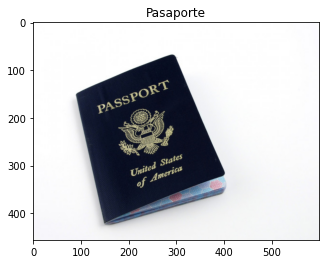

In [5]:
#@title Selecciona la imagen { run: "auto" }
Loro='/content/drive/MyDrive/Colab Notebooks/loro.jpg'
Pasaporte='/content/drive/MyDrive/Colab Notebooks/PASAPORTE.jpg'
SistemaSolar='/content/drive/MyDrive/Colab Notebooks/SisSolar.jpg'
Coliseo='/content/drive/MyDrive/Colab Notebooks/Coliseo.jpg'
Isla='/content/drive/MyDrive/Colab Notebooks/Isla.jpg'
Selva='/content/drive/MyDrive/Colab Notebooks/Selva.jpg'
Imagen = 'Pasaporte' #@param ["Loro", "Pasaporte", "SistemaSolar", "Coliseo", "Isla", "Selva"]

if Imagen == 'Loro':
  image = get_image(Loro)
  plot2_image(image, 'Loro')
elif Imagen == 'Pasaporte':
  image = get_image(Pasaporte)
  plot2_image(image, 'Pasaporte')
elif Imagen == 'SistemaSolar':
  image = get_image(SistemaSolar)
  plot2_image(image, 'SistemaSolar')
elif Imagen == 'Isla':
  image = get_image(Isla)
  plot2_image(image, 'Isla')
elif Imagen == 'Selva':
  image = get_image(Selva)
  plot2_image(image, 'Selva')
elif Imagen == 'Coliseo':
  image = get_image(Coliseo)
  plot2_image(image, 'Coliseo')

In [6]:
#Proceso de copia de la imagen y visualización de información
work_image=image_copy(image)
image_info(work_image)

This image is int64
with dimensions (456, 600, 3)


<Figure size 7200x7200 with 0 Axes>

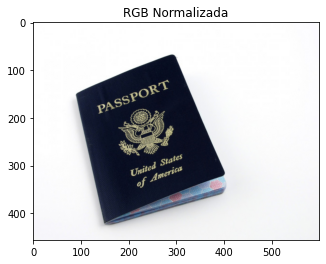

In [7]:
#Normalización de la imagen y conversión del espacio RGB a YIQ
work_image=image_norm(work_image)
plot2_image(work_image,'RGB Normalizada',cmap=None)

<Figure size 7200x7200 with 0 Axes>

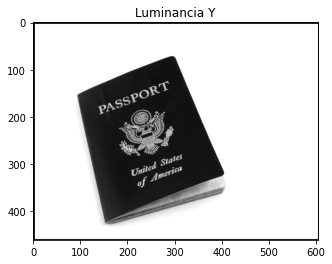

In [8]:
ima, fmax, cmax, dato, f1, c1 = padding (work_image, 7)
y, i, q = image_RGB2YIQ(ima)
plot2_image(y,'Luminancia Y',cmap='gray')

##Visualización individual de los filtros
###Morfología
La morfología matemática se basa en operaciones de teoría de
conjuntos. En el caso de imágenes binarias, los conjuntos tratados
son subconjuntos de Z2 y en el de las imágenes en escala de grises,
se trata de conjuntos de puntos con coordenadas en Z3

In [9]:
#Función que contiene la operación básica de la morfología EROSIÓN
def erosion(y):
  return np.min(y)

#Función que contiene la operación básica de la morfología DILATACIÓN
def dilatation(y):
  return np.max(y)

#Función borde morfológio apertura interna
def internal_border(y: np.array):
  return y[1,1]-erosion(y)

#Función borde morfológio apertura externa
def external_border(y: np.array):
  return dilatation(y)-y[1,1]

#Función filtro morfológico mediano
def median(y):
  return np.median(y)


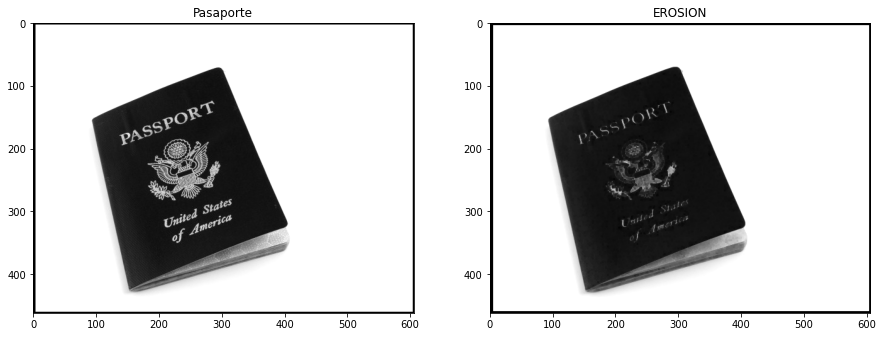

In [10]:
#Filtro morfológico EROSIÓN
final_image = convolucion(y, erosion)
ima_ero = image_copy(final_image)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image,'gray')
axes[1].set_title('EROSION')
plt.show()

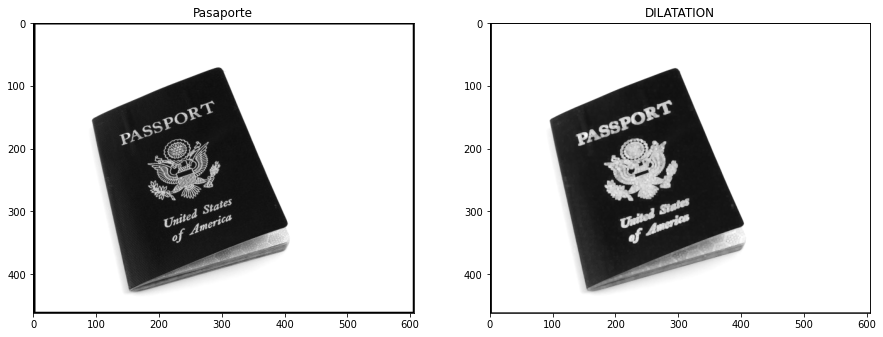

In [11]:
#Filtro morfológico DILATACIÓN
final_image = convolucion(y, dilatation)
ima_dil = image_copy(final_image)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image,'gray')
axes[1].set_title('DILATATION')
plt.show()

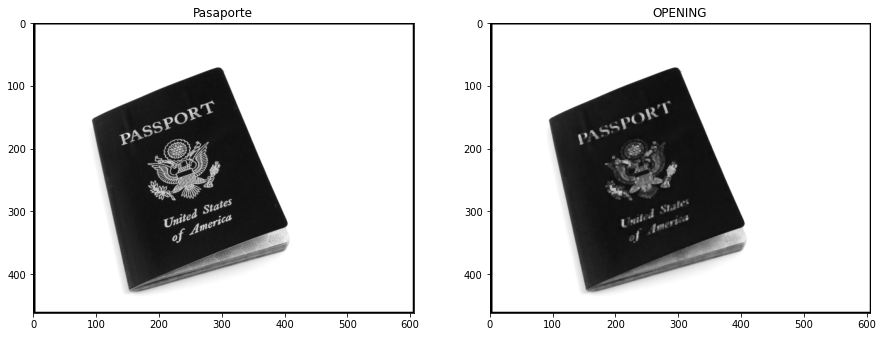

In [12]:
#Filtro morfológico APERTURA
final_image = convolucion(y, erosion)
final_image2 = convolucion(final_image, dilatation)
ima_ape = image_copy(final_image2)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image2,'gray')
axes[1].set_title('OPENING')
plt.show()

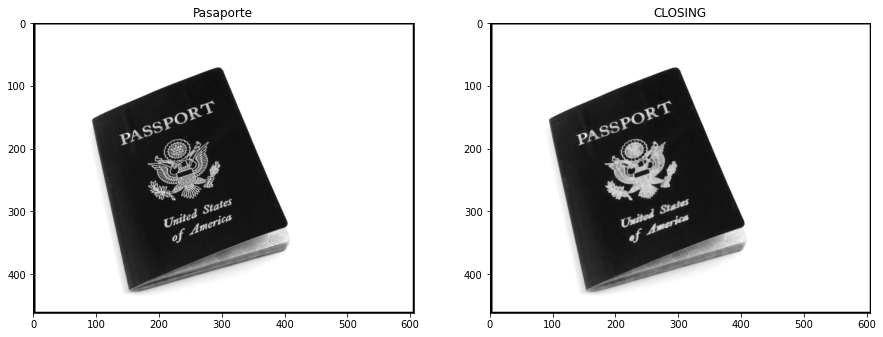

In [13]:
#Filtro morfológico CIERRE
final_image = convolucion(y, dilatation)
final_image2 = convolucion(final_image, erosion)
ima_cie = image_copy(final_image2)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image2,'gray')
axes[1].set_title('CLOSING')
plt.show()

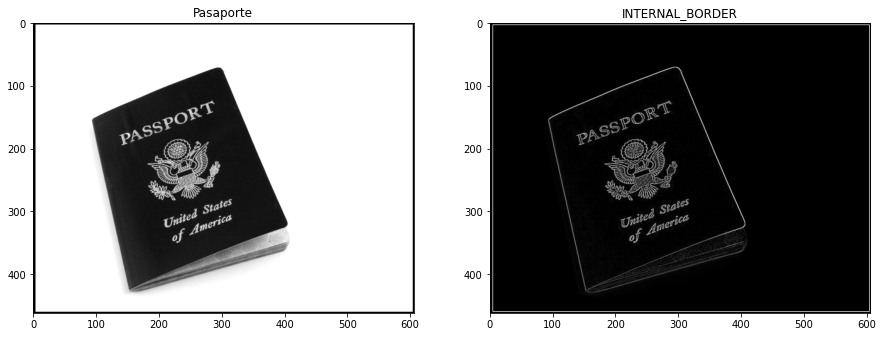

In [14]:
#Filtro morfológico BORDE FRONTERA INTERNA
final_image = convolucion(y, internal_border)
ima_int = image_copy(final_image)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image,'gray')
axes[1].set_title('INTERNAL_BORDER')
plt.show()

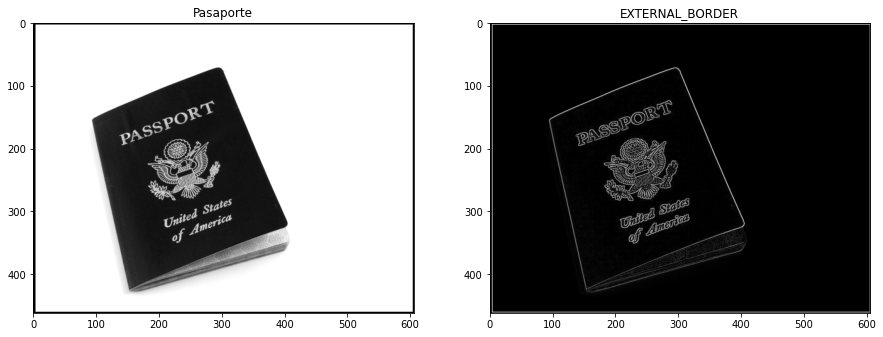

In [15]:
#Filtro morfológico BORDE FRONTERA EXTERNA
final_image = convolucion(y, external_border)
ima_ext = image_copy(final_image)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image,'gray')
axes[1].set_title('EXTERNAL_BORDER')
plt.show()

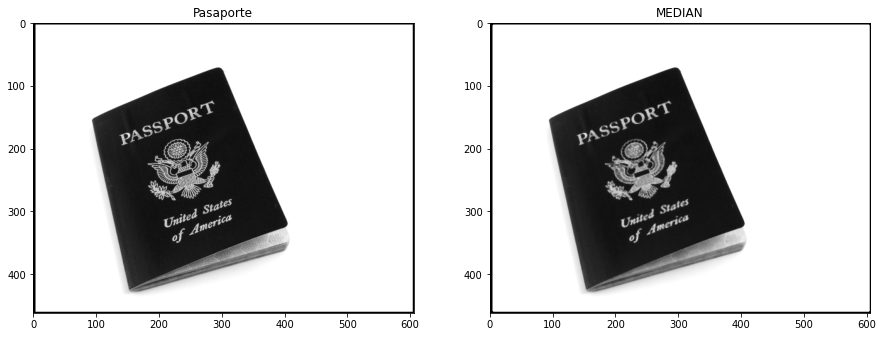

In [16]:
#Filtro morfológico MEDIANA
final_image = convolucion(y, median)
ima_med = image_copy(final_image)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image,'gray')
axes[1].set_title('MEDIAN')
plt.show()

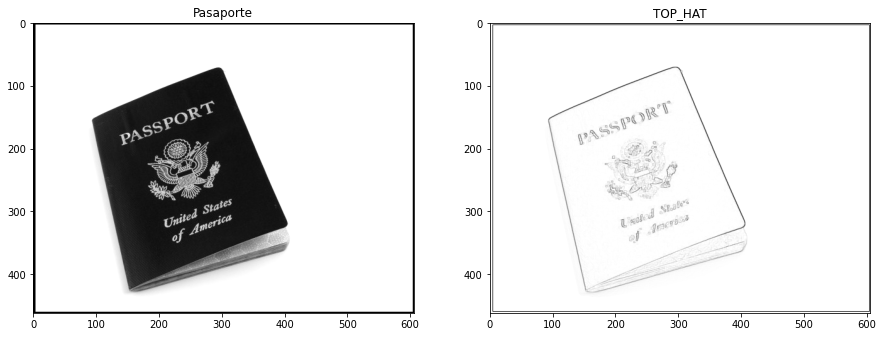

In [17]:
#Filtro morfológico TOP_HAT
final_image = convolucion(y, erosion)
final_image1 = convolucion(final_image, dilatation)
final_image2 = final_image - final_image1
ima_top_hat = image_copy(final_image2)
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(final_image2,'gray')
axes[1].set_title('TOP_HAT')
plt.show()

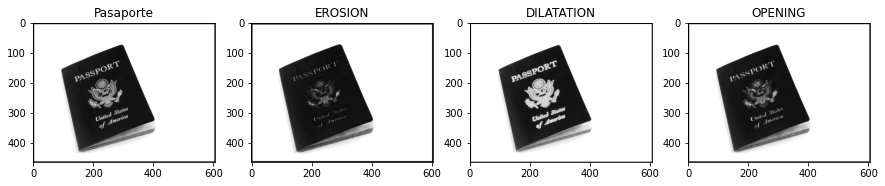

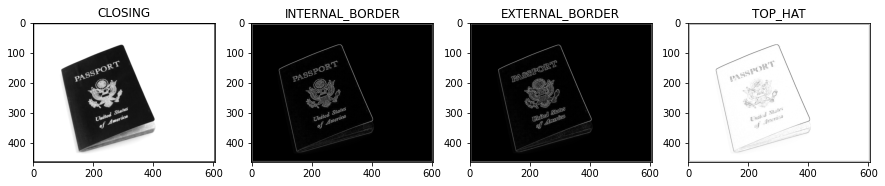

In [20]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(y,'gray')
axes[0].set_title(Imagen)
axes[1].imshow(ima_ero,'gray')
axes[1].set_title('EROSION')
axes[2].imshow(ima_dil,'gray')
axes[2].set_title('DILATATION')
axes[3].imshow(ima_ape,'gray')
axes[3].set_title('OPENING')
plt.show()
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(15,15)
axes[0].imshow(ima_cie,'gray')
axes[0].set_title('CLOSING')
axes[1].imshow(ima_int,'gray')
axes[1].set_title('INTERNAL_BORDER')
axes[2].imshow(ima_ext,'gray')
axes[2].set_title('EXTERNAL_BORDER')
axes[3].imshow(ima_top_hat,'gray')
axes[3].set_title('TOP_HAT')
plt.show()


###Resultados
Desarrollo del aplicativo que permite, levantar una imagen en nivel de grises (o que la convierta a YIQ y retenga solo el Y) y aplique el filtrado morfológico:

*   Erosión (tomar el mínimo valor de luminancia de la vecindad)
*   Dilatación (máximo)
*   Apertura
*   Cierre
*   Borde morfológico (frontera interna y externa)
*   Mediana
*   Top-hat
El aplicativo implementa una función de copiado de la imagen procesada (saved_image), permite al usuario aplicar dos o más filtros. 

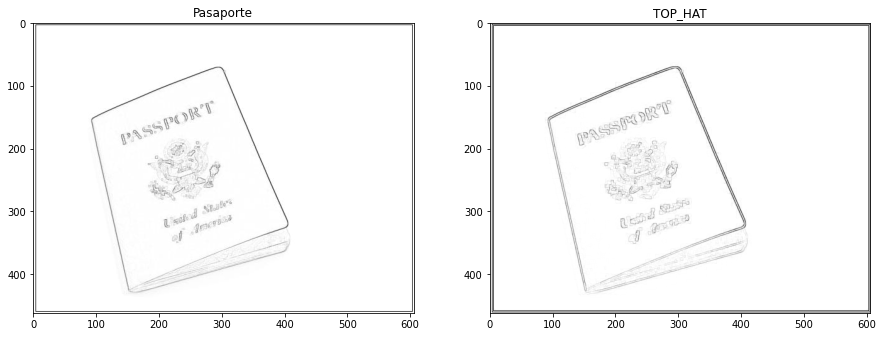

In [23]:
#@title Resultados { run: "auto" }
Option = 'saved_image' #@param ["original_image", "saved_image"]
Filter = 'top_hat' #@param ["erosion", "dilatation" ,"opening","closing", "internal_border", "external_border", "median", "top_hat"]

if Option == 'original_image' and Filter=='erosion':
  final_image = convolucion(y, erosion)
  save_im = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('EROSION')
  plt.show()
elif Option == 'original_image' and Filter=='erosion':
  final_image = convolucion(y, dilatation)
  save_im = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('DILATATION')
  plt.show()
elif Option == 'original_image' and Filter=='opening':
  final_image = convolucion(y, erosion)
  final_image2 = convolucion(final_image, dilatation)
  save_im = save_image(final_image2)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image2,'gray')
  axes[1].set_title('OPENING')
  plt.show()
elif Option == 'original_image' and Filter=='closing':
  final_image = convolucion(y, dilatation)
  final_image2 = convolucion(final_image, erosion)
  save_im = save_image(final_image2)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image2,'gray')
  axes[1].set_title('CLOSING')
  plt.show()
elif Option == 'original_image' and Filter=='internal_border':
  final_image = convolucion(y, internal_border)
  save_im = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('INTERNAL_BORDER')
  plt.show() 
elif Option == 'original_image' and Filter=='external_border':
  final_image = convolucion(y, external_border)
  save_im = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('EXTERNAL_BORDER')
  plt.show()
elif Option == 'original_image' and Filter=='median':
  final_image = convolucion(y, median)
  save_im = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('MEDIAN')
  plt.show()
elif Option == 'original_image' and Filter=='top_hat':
  final_image = convolucion(y, erosion)
  final_image1 = convolucion(final_image, dilatation)
  final_image2 = final_image - final_image1
  save_im = save_image(final_image2)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(y,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image2,'gray')
  axes[1].set_title('TOP_HAT')
  plt.show()
if Option == 'saved_image' and Filter=='erosion':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, erosion)
  save_im2 = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('EROSION')
  plt.show()
elif Option == 'saved_image' and Filter=='erosion':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, dilatation)
  save_im2 = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('DILATATION')
  plt.show()
elif Option == 'saved_image' and Filter=='opening':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, erosion)
  final_image2 = convolucion(final_image, dilatation)
  save_im2 = save_image(final_image2)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image2,'gray')
  axes[1].set_title('OPENING')
  plt.show()
elif Option == 'saved_image' and Filter=='closing':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, dilatation)
  final_image2 = convolucion(final_image, erosion)
  save_im2 = save_image(final_image2)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image2,'gray')
  axes[1].set_title('CLOSING')
  plt.show()
elif Option == 'original_image' and Filter=='internal_border':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, internal_border)
  save_im2 = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('INTERNAL_BORDER')
  plt.show() 
elif Option == 'saved_image' and Filter=='external_border':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, external_border)
  save_im2 = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('EXTERNAL_BORDER')
  plt.show()
elif Option == 'saved_image' and Filter=='median':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, median)
  save_im2 = save_image(final_image)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image,'gray')
  axes[1].set_title('MEDIAN')
  plt.show()
elif Option == 'saved_image' and Filter=='top_hat':
  save_im = get_image('/content/drive/MyDrive/Colab Notebooks/imagen_final.jpg')
  final_image = convolucion(save_im, erosion)
  final_image1 = convolucion(final_image, dilatation)
  final_image2 = final_image - final_image1
  save_im2 = save_image(final_image2)
  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(15,15)
  axes[0].imshow(save_im,'gray')
  axes[0].set_title(Imagen)
  axes[1].imshow(final_image2,'gray')
  axes[1].set_title('TOP_HAT')
  plt.show()

#### Análisis de los resultados:


*   Se crea una función que permite operar una imagen con un elemento estructurante de 3x3, posterior aplicar filtros morfológicos, mediante la implementación de un doble ciclo FOR se recorre cada pixel de la imagen multiplicando por el elemento estructurante, el producto de esta multiplicación se posiciona en una nueva matriz.
*   El aplicativo permite al usuario guardar la imagen procesada como una nueva imagen en nivel de grises, al seleccionar saved_image se puede aplicar dos o más filtros a la imagen previamente procesada. 
*   Algunas de las principales aplicaciones de los filtros morfológicos en el procesado de imágenes son la extracción de objetos de la imagen, reducción del ruido, detección de bordes o contornos. 